# Retailer Segmentation Using RFM Analysis

**Objective:** Perform RFM segmentation on retailer transaction data to identify behavioral cohorts and support downstream commercial analytics.

**Business Value:** Enables churn risk detection, revenue forecasting, and account prioritization.

This notebook covers data loading, cleaning, RFM feature engineering, and retailer-level aggregation used in a customer segmentation and churn analysis project. It has been cleaned for portfolio use (no credentials or environment-specific setup).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Suppress warnings and adjust display options
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

import os

data_path = "../data/transactions_sample.csv"
data = pd.read_csv(data_path, parse_dates=["date"])

print("=== DATA LOADED (LOCAL TEST) ===")
print(f"Shape: {data.shape}")
print("Date range:", data['date'].min(), "to", data['date'].max())

=== DATA LOADED (LOCAL TEST) ===
Shape: (25000, 19)
Date range: 2021-01-04 00:00:00 to 2024-12-24 00:00:00


In [2]:
data.head()

,date,invoice_type,invoice_no,sku_code,product_category,brand_name,retailer_code,retailer_name,retailer_type,distributor_code,distributor_name,distributor_type,list_price,price_sold,quantity_sold,invoice_value,discount_amount,discount_percentage,unit_profit
0,2023-04-18,Normal,QRA-007-23RT05004930-01,f2db2c8f8efc6e32887f3b6cd803c1febcc2564b,HAIR CARE,Brand 7,47007f559dfa65b7d3930ab1e68325bdffd4ace6,Retailer 360,INDEPENDENT,Q007,Distributor C,Exclusive,11.4,8.10,6,48.60,3.30,28.947369,0.12
1,2024-11-04,Normal,QRA-004-24RT22008020-01,e76beb42a6a6116cb8209c0d3af1b3eba39f1370,SKIN CLEANSING,Brand 13,47007f559dfa65b7d3930ab1e68325bdffd4ace6,Retailer 360,INDEPENDENT,Q004,Distributor A,Exclusive,10.1,6.20,6,37.20,3.90,38.613860,-0.87
2,2021-08-16,Normal,QRA-007-21RT03014440-01,18227677d8061c74c89a43c49aee39e3bacd22a2,HAIR CARE,Brand 25,4e0c601935c96d47573996260cd8890a32538d33,Retailer 400,INDEPENDENT,Q007,Distributor C,Exclusive,6.2,3.35,3,10.05,2.85,45.967743,-0.99
3,2021-07-12,Normal,QRA-004-21RT04011340-01,ecfc26996627967c9aa24045bf7d2fb0489090e1,SKIN CLEANSING,Brand 13,44d3cc6a8551ed1b3e61940435a86c69643434e3,Retailer 349,INDEPENDENT,Q004,Distributor A,Exclusive,3.5,2.70,6,16.20,0.80,22.857143,0.25
4,2021-01-13,Normal,QRA-007-21RT10000810-01,ea82b434e7240d569c3a52d5307570b56d1f25e1,HAIR CARE,Brand 7,07c301cca55f5773607d27ee27b2d7646c0c6bbc,Retailer 33,INDEPENDENT,Q007,Distributor C,Exclusive,5.6,5.35,6,32.10,0.25,4.464286,1.43


In [3]:
# Set display options
# Basic dataset overview
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nColumn names and data types:")
print(data.dtypes)
print("\n" + "="*50)

=== DATASET OVERVIEW ===
Dataset shape: (25000, 19)
Memory usage: 18.57 MB

Column names and data types:
date                   datetime64[ns]
invoice_type                   object
invoice_no                     object
sku_code                       object
product_category               object
brand_name                     object
retailer_code                  object
retailer_name                  object
retailer_type                  object
distributor_code               object
distributor_name               object
distributor_type               object
list_price                    float64
price_sold                    float64
quantity_sold                   int64
invoice_value                 float64
discount_amount               float64
discount_percentage           float64
unit_profit                   float64
dtype: object



In [4]:
# Check for missing values
print("=== MISSING VALUES ANALYSIS ===")
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)
print(missing_summary)
print("\n" + "="*50)

=== MISSING VALUES ANALYSIS ===
                     Missing_Count  Missing_Percentage
date                             0                 0.0
distributor_name                 0                 0.0
discount_percentage              0                 0.0
discount_amount                  0                 0.0
invoice_value                    0                 0.0
quantity_sold                    0                 0.0
price_sold                       0                 0.0
list_price                       0                 0.0
distributor_type                 0                 0.0
distributor_code                 0                 0.0
invoice_type                     0                 0.0
retailer_type                    0                 0.0
retailer_name                    0                 0.0
retailer_code                    0                 0.0
brand_name                       0                 0.0
product_category                 0                 0.0
sku_code                         

In [5]:
# Check for duplicates
duplicate_count = data.duplicated().sum()
print(f"\nDuplicate rows: {duplicate_count}")
print(f"Duplicate percentage: {duplicate_count/len(data)*100:.2f}%")
print("\n" + "="*60)


Duplicate rows: 0
Duplicate percentage: 0.00%



In [6]:
# Aggregate to retailer level
retailer_agg = (
    data.groupby(["retailer_code", "retailer_name"], dropna=False)
        .agg(
            last_transaction_date = ("date", "max"),
            total_sales           = ("invoice_value", "sum"),
            total_units_sold      = ("quantity_sold", "sum"),
            num_transactions      = ("invoice_no", pd.Series.nunique),
            num_skus_sold         = ("sku_code", pd.Series.nunique),
            avg_price_sold        = ("price_sold", "mean"),
            avg_discount_pct      = ("discount_percentage", "mean"),
            avg_unit_profit       = ("unit_profit", "mean"),
        )
        .reset_index()
)

# Weighted average price (guard against div-by-zero)
retailer_agg["weighted_avg_price"] = np.where(
    retailer_agg["total_units_sold"] > 0,
    retailer_agg["total_sales"] / retailer_agg["total_units_sold"],
    np.nan
)

print("Retailer-level aggregation complete. Shape:", retailer_agg.shape)
retailer_agg.head()

Retailer-level aggregation complete. Shape: (100, 11)


,retailer_code,retailer_name,last_transaction_date,total_sales,total_units_sold,num_transactions,num_skus_sold,avg_price_sold,avg_discount_pct,avg_unit_profit,weighted_avg_price
0,034ba7dd7440136b9ebfdafc827233a50796468e,Retailer 21,2023-07-27,1901.95,535,30,65,4.359589,29.833621,-0.191370,3.555047
1,07c301cca55f5773607d27ee27b2d7646c0c6bbc,Retailer 33,2024-12-11,8882.50,3011,130,176,4.146805,21.917884,0.148910,2.950017
2,07f317691c49caf14ac0beab7f4c68bf71858a13,Retailer 37,2024-12-24,9720.00,4071,270,115,3.113731,35.457141,-0.457599,2.387620
3,098a3d842e76b6ff55df14bf7e807fdee858ac6a,Retailer 46,2024-12-18,3268.35,1040,38,31,4.047273,30.540667,-0.413636,3.142644
4,0c0a5d4293715c25c66720e74c9d238ff1016f59,Retailer 57,2024-12-04,13135.85,3086,116,168,4.945614,26.872808,-0.018450,4.256594


In [7]:
print("=== DATA QUALITY CHECKS (RAW DATA) ===")
# 1) Nulls by column
null_counts = data.isna().sum().sort_values(ascending=False)
print("\nNull counts per column:\n", null_counts)

# 2) NaT in date
nat_count = data["date"].isna().sum()
print(f"\nNaT in 'date': {nat_count}")

# 3) Any infinities (on numeric columns)
num_cols = data.select_dtypes(include=[np.number]).columns
inf_mask = np.isinf(data[num_cols]).any()
if inf_mask.any():
    print("\nColumns containing ±inf:")
    print(inf_mask[inf_mask].index.tolist())
else:
    print("\nNo ±inf detected in numeric columns.")

# 4) Duplicate invoice_no (optional signal of duplicate transactions)
dup_invoices = data["invoice_no"].duplicated(keep=False).sum()
print(f"\nRows with duplicated invoice_no: {dup_invoices}")

print("\n=== DATA QUALITY CHECKS (AGGREGATED) ===")
# 5) Aggregated-level checks
agg_nulls = retailer_agg.isna().sum().sort_values(ascending=False)
print("\nNull counts per column in retailer_agg:\n", agg_nulls)

# 6) NaT in aggregated date
agg_nat = retailer_agg["last_transaction_date"].isna().sum()
print(f"\nNaT in 'last_transaction_date' (retailer_agg): {agg_nat}")

=== DATA QUALITY CHECKS (RAW DATA) ===

Null counts per column:
 date                   0
distributor_name       0
discount_percentage    0
discount_amount        0
invoice_value          0
quantity_sold          0
price_sold             0
list_price             0
distributor_type       0
distributor_code       0
invoice_type           0
retailer_type          0
retailer_name          0
retailer_code          0
brand_name             0
product_category       0
sku_code               0
invoice_no             0
unit_profit            0
dtype: int64

NaT in 'date': 0

No ±inf detected in numeric columns.

Rows with duplicated invoice_no: 19744

=== DATA QUALITY CHECKS (AGGREGATED) ===

Null counts per column in retailer_agg:
 retailer_code            0
retailer_name            0
last_transaction_date    0
total_sales              0
total_units_sold         0
num_transactions         0
num_skus_sold            0
avg_price_sold           0
avg_discount_pct         0
avg_unit_profit         

### 📌 Output Note

In the original capstone project, retailer-level features were exported for downstream churn modeling and revenue-at-risk analysis. For portfolio purposes, this notebook focuses on feature engineering and segmentation; modeling and risk analytics may be added in a subsequent notebook.

In [8]:
# Choose analysis date = one day after the last transaction seen
try:
    analysis_date = (data["date"].max() + pd.Timedelta(days=1)).normalize()
except Exception:
    analysis_date = (retailer_agg["last_transaction_date"].max() + pd.Timedelta(days=1)).normalize()

# Build RFM from aggregated columns
rfm = retailer_agg[["retailer_code", "retailer_name", "last_transaction_date",
                    "num_transactions", "total_sales"]].copy()

rfm = rfm.rename(columns={
    "num_transactions": "Frequency",
    "total_sales": "Monetary"
})

# Recency in days
rfm["RecencyDays"] = (analysis_date - rfm["last_transaction_date"]).dt.days.astype("Int32")

# Clean numerics
rfm["Frequency"] = pd.to_numeric(rfm["Frequency"], errors="coerce").fillna(0).astype("Int32")
rfm["Monetary"]  = pd.to_numeric(rfm["Monetary"],  errors="coerce").replace([np.inf, -np.inf], np.nan).fillna(0).astype("float32")

print("As-of date for Recency:", analysis_date.date())
rfm.head()

As-of date for Recency: 2024-12-25


,retailer_code,retailer_name,last_transaction_date,Frequency,Monetary,RecencyDays
0,034ba7dd7440136b9ebfdafc827233a50796468e,Retailer 21,2023-07-27,30,1901.949951,517
1,07c301cca55f5773607d27ee27b2d7646c0c6bbc,Retailer 33,2024-12-11,130,8882.500000,14
2,07f317691c49caf14ac0beab7f4c68bf71858a13,Retailer 37,2024-12-24,270,9720.000000,1
3,098a3d842e76b6ff55df14bf7e807fdee858ac6a,Retailer 46,2024-12-18,38,3268.350098,7
4,0c0a5d4293715c25c66720e74c9d238ff1016f59,Retailer 57,2024-12-04,116,13135.849609,21


In [9]:
# R: Recency (days since last purchase) — lower is better
# 5: ≤30 | 4: 31–90 | 3: 91–180 | 2: 181–365 | 1: >365
def score_recency_abs(x):
    if pd.isna(x): return 1
    x = float(x)
    if x <= 30:   return 5
    if x <= 90:   return 4
    if x <= 180:  return 3
    if x <= 365:  return 2
    return 1

rfm["R_Score_abs"] = rfm["RecencyDays"].apply(score_recency_abs).astype("Int8")
print("R_Score_abs created. Preview:\n", rfm[["RecencyDays","R_Score_abs"]].head())

R_Score_abs created. Preview:
    RecencyDays  R_Score_abs
0          517            1
1           14            5
2            1            5
3            7            5
4           21            5


In [10]:
# F: Frequency — higher is better, but use asymmetric cuts to shrink the top buckets
# Choose asymmetric percentiles (edit if needed)
F_pts = [0.40, 0.70, 0.90, 0.97]  # 40%, 70%, 90%, 97%
F_qs  = rfm["Frequency"].quantile(F_pts).to_list()
print("Frequency asymmetric cutoffs (P40,P70,P90,P97):", F_qs)

def score_frequency_asym(x, qs=F_qs):
    if x <= qs[0]: return 1
    elif x <= qs[1]: return 2
    elif x <= qs[2]: return 3
    elif x <= qs[3]: return 4
    else: return 5

rfm["F_Score_asym"] = rfm["Frequency"].apply(score_frequency_asym).astype("Int8")
print("F_Score_asym created. Preview:\n", rfm[["Frequency","F_Score_asym"]].head())

Frequency asymmetric cutoffs (P40,P70,P90,P97): [67.2, 129.3, 245.9000000000001, 342.42]
F_Score_asym created. Preview:
    Frequency  F_Score_asym
0         30             1
1        130             3
2        270             4
3         38             1
4        116             2


In [11]:
# M: Monetary — score by contribution to total revenue (Pareto-style)
# 5: top contributors (<= 50% cum share) | 4: <=80% | 3: <=95% | 2: <=99% | 1: >99%

# Sort Monetary desc and compute cumulative share
tmp = rfm[["Monetary"]].copy().sort_values("Monetary", ascending=False)
tmp["cum_share"] = tmp["Monetary"].cumsum() / tmp["Monetary"].sum()

# Map each row to its cumulative share via descending rank
rank_idx = rfm["Monetary"].rank(method="first", ascending=False).astype(int) - 1
cum_share_lookup = tmp["cum_share"].reset_index(drop=True)
rfm["_cum_share"] = cum_share_lookup.iloc[rank_idx].values

def score_monetary_pareto(s):
    if s <= 0.50:   return 5   # top ~50% of revenue contributors
    elif s <= 0.80: return 4
    elif s <= 0.95: return 3
    elif s <= 0.99: return 2
    else:           return 1

rfm["M_Score_pareto"] = rfm["_cum_share"].apply(score_monetary_pareto).astype("Int8")
print("M_Score_pareto created. Preview:\n", rfm[["Monetary","_cum_share","M_Score_pareto"]].head())

# (optional) clean helper column after inspection
# rfm.drop(columns=["_cum_share"], inplace=True)

M_Score_pareto created. Preview:
        Monetary  _cum_share  M_Score_pareto
0   1901.949951    0.985206               2
1   8882.500000    0.837033               3
2   9720.000000    0.825045               3
3   3268.350098    0.955983               2
4  13135.849609    0.788256               4


In [12]:
# New Segmentation 
def segment_afp_with_hibernating_lost(row):
    r, f, m = row["R_Score_abs"], row["F_Score_asym"], row["M_Score_pareto"]

    # 1) Top & growth tiers
    if r >= 4 and f >= 4 and m >= 4:
        return "VIP"
    elif r >= 3 and f >= 3:
        return "Loyal"
    elif r >= 4 and f >= 2:
        return "Potential Loyalist"
    elif r >= 4 and f <= 2:
        return "New"
    elif 2 <= r <= 3 and 2 <= f <= 3:
        return "Need Attn"

    # 2) Lapsed tiers
    if r == 1 and f == 1 and m == 1:
        return "Lost"  # absolute worst
    elif r == 1 and f <= 2 and m <= 2:
        return "Hibernating"  # long inactive + low activity/spend
    elif r <= 2:
        return "Risk of Churn"  # lapsed but had some value worth saving

    # 3) Fallback (rare)
    return "Need Attn"

# Apply and summarize
rfm["RFM_Segment_AFP"] = rfm.apply(segment_afp_with_hibernating_lost, axis=1)

order = ["VIP","Loyal","Potential Loyalist","New","Need Attn","Risk of Churn","Hibernating","Lost"]
summary = (rfm["RFM_Segment_AFP"]
           .value_counts()
           .reindex(order, fill_value=0)
           .to_frame("RetailerCount"))
summary["% of Retailers"] = (summary["RetailerCount"]/len(rfm)*100).round(2)
print(summary)

                    RetailerCount  % of Retailers
RFM_Segment_AFP                                  
VIP                             8             8.0
Loyal                          16            16.0
Potential Loyalist             26            26.0
New                            22            22.0
Need Attn                       7             7.0
Risk of Churn                   8             8.0
Hibernating                     8             8.0
Lost                            5             5.0


### Data Handoff for Downstream Modeling (Context Only)

In the original capstone project, the enriched RFM output (including Recency, Frequency, Monetary scores and behavioral segments) was merged with the retailer-level aggregate dataset to create a unified analytical table. This handoff file was then used in downstream work such as churn analysis, revenue-at-risk estimation, and commercial account prioritization.

For this portfolio version, the focus is on RFM feature engineering and segmentation, so the export and merge steps are omitted. The segmentation table produced in this notebook represents the final analytical output.

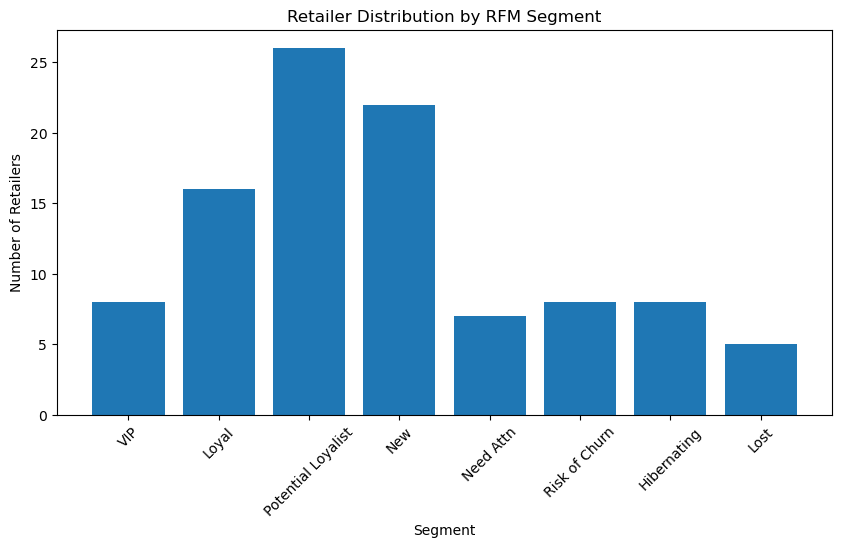

In [13]:
# Visualizing Segment Distribution
plt.figure(figsize=(10, 5))
plt.bar(summary.index, summary["RetailerCount"])
plt.title("Retailer Distribution by RFM Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Retailers")
plt.xticks(rotation=45)
plt.show()

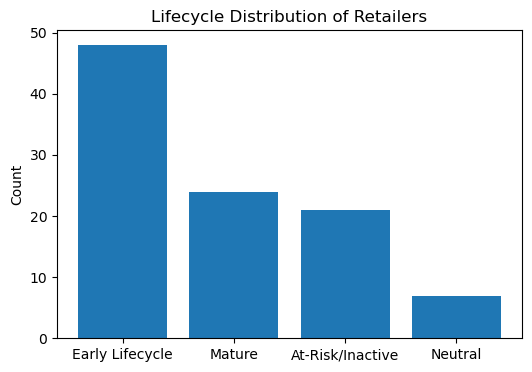

In [14]:
# Lifecycle View (Collapsed Segments)
lifecycle = {
    "Early Lifecycle": summary.loc[["New", "Potential Loyalist"]]["RetailerCount"].sum(),
    "Mature": summary.loc[["Loyal", "VIP"]]["RetailerCount"].sum(),
    "At-Risk/Inactive": summary.loc[["Risk of Churn", "Hibernating", "Lost"]]["RetailerCount"].sum(),
    "Neutral": summary.loc[["Need Attn"]]["RetailerCount"].sum()
}

plt.figure(figsize=(6,4))
plt.bar(lifecycle.keys(), lifecycle.values())
plt.title("Lifecycle Distribution of Retailers")
plt.ylabel("Count")
plt.show()

### 📌 Key Insights from RFM Segmentation

1. **Almost half of the retailer base is still early in the lifecycle.**  
   `New` and `Potential Loyalist` segments together account for **48%** of all retailers, indicating strong acquisition momentum but still-developing loyalty maturity.

2. **A quarter of retailers are already mature and engaged.**  
   `Loyal` and `VIP` retailers represent **24%** of the base and are likely responsible for a disproportionate share of sales, making them strategic accounts for protection and account management.

3. **Churn-related segments form a meaningful minority.**  
   `Risk of Churn`, `Hibernating`, and `Lost` together make up **21%** of retailers, highlighting opportunities for retention and reactivation initiatives.

4. **A small segment sits in a neutral zone.**  
   `Need Attn` comprises **7%** of retailers, representing accounts that could either be developed into Loyal or drift into churn risk depending on engagement.

### 🎯 Potential Business Actions

- **Accelerate onboarding (`New → Potential Loyalist → Loyal`):**  
  Targeted promotions, minimum order incentives, and product education can increase ordering cadence and basket size.

- **Convert `Potential Loyalist` into `Loyal`:**  
  This segment has the highest representation (**26%**) and represents the strongest near-term growth opportunity.

- **Protect and grow `VIP` and `Loyal`:**  
  Maintain service levels, stock availability, and targeted upsell to reduce churn risk among high-value accounts.

- **Reactivate churn-risk segments:**  
  `Risk of Churn`, `Hibernating`, and `Lost` (combined **21%**) may benefit from reactivation programs, discounts, or supply-side interventions.

- **Monitor `Need Attn`:**  
  These accounts are early signals for churn; proactive engagement may prevent leakage.

### This segmentation provides a foundation for future churn analysis, revenue-at-risk estimation, and commercial prioritization.